In [93]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure
from matplotlib.pyplot import figure
from matplotlib.animation import FFMpegWriter
from IPython.display import Image

In [5]:
#tamanho da malha (a priori)
N = 50

In [6]:
def cria_malhas(N,tipo):
    malha = np.zeros((N,N))
    if tipo == 1:
        #malha trivial com todos os spins positivos
        for i in range(N):
            for j in range(N):
                malha[i][j] = 1
    elif tipo == 2:
        #malha trivial com todos os spins negativos
        for i in range(N):
            for j in range(N):
                malha[i][j] = -1
    elif tipo == 3:
        #malha 25% dos spins positivos (e 75% dos spins negativos)
        init_random = np.random.random((N,N))
        malha[init_random <= 0.25] = 1
        malha[init_random >= 0.25] = -1
    elif tipo == 4:
        #malha 75% dos spins positivos (e 25% dos spins negativos)
        init_random = np.random.random((N,N))
        malha[init_random <= 0.75] = 1
        malha[init_random >= 0.75] = -1
    elif tipo == 5:
        #malha completamente randomica
        init_random = np.random.random((N,N))
        prob = np.random.random()
        malha[init_random <= prob] = 1
        malha[init_random >= prob] = -1
    return malha

In [7]:
#aqui foi desconsiderado as condições de contorno (fazer o toro)
def get_energy(malha):
    # soma entre os vizinhos próximos
    kern = generate_binary_structure(2,1)
    kern[1][1] = False
    arr = - malha * convolve(malha, kern, mode='constant') #convolução
    return arr.sum()

In [26]:
@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(spin_arr, times, BJ, energy): #times = passos
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    for t in range(0,times-1):
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] 
        spin_f = spin_i*-1 
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy
    return net_spins, net_energy

/home/gui/anaconda3/lib/python3.8/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [9]:
def mostrarResultados(malha, spins, energies, beta):
    bfig, axes = plt.subplots(1, 3, figsize=(15,6))
    axes[0].imshow(malha)
    ax = axes[1]
    ax.plot(spins/N**2)
    ax.set_xlabel('Passos de Monte Carlo')
    ax.set_ylabel('Magnetização Média')
    ax.grid()
    ax = axes[2]
    ax.plot(energies)
    ax.set_xlabel('Passos de Monte Carlo')
    ax.set_ylabel(r'Energia $E/J$')
    ax.grid()
    bfig.tight_layout()
    bfig.suptitle(f"Magnetização Média e Energia para beta = {beta}",  y=1.07, size=20)
    plt.show()

In [10]:
def main(N, tipo, beta, passosMC):
    malha = cria_malhas(N, tipo)
    get_energy(malha)
    spins, energies = metropolis(malha, passosMC, beta, get_energy(malha))
    return malha, spins, energies

<font size="5"> Exemplo do uso do algoritmo de metropolis para uma malha aleatória de dimensão linear = 50: </font>

In [21]:
N = 50 #tamanho linear da malha
tipo = 5 #tipo da malha: aleatória
bj = 0.7 #1/temperatura
passosMC = 1e6 #número de passos MC

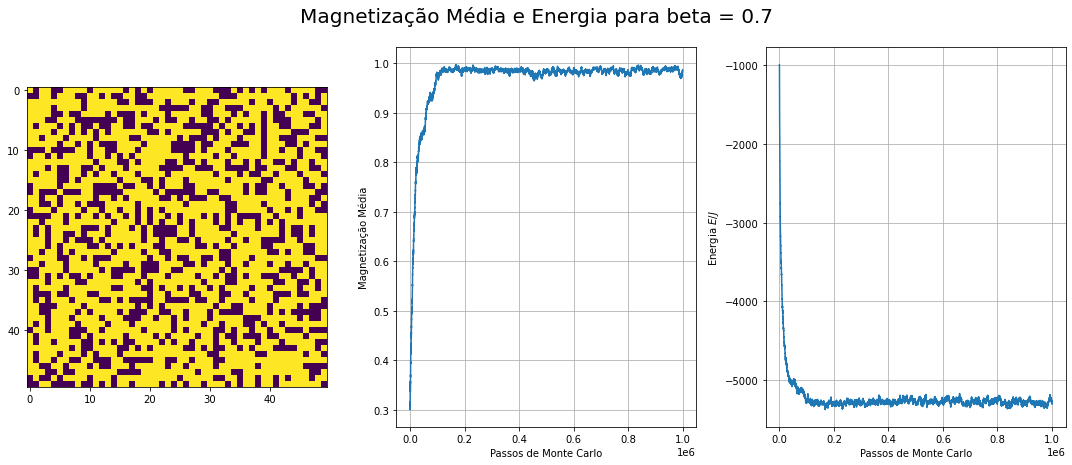

In [14]:
malhaExpl1, spinsExpl1, energiesExpl1 = main(N, tipo, bj, passosMC)
mostrarResultados(malhaExpl1, spinsExpl1, energiesExpl1, bj)

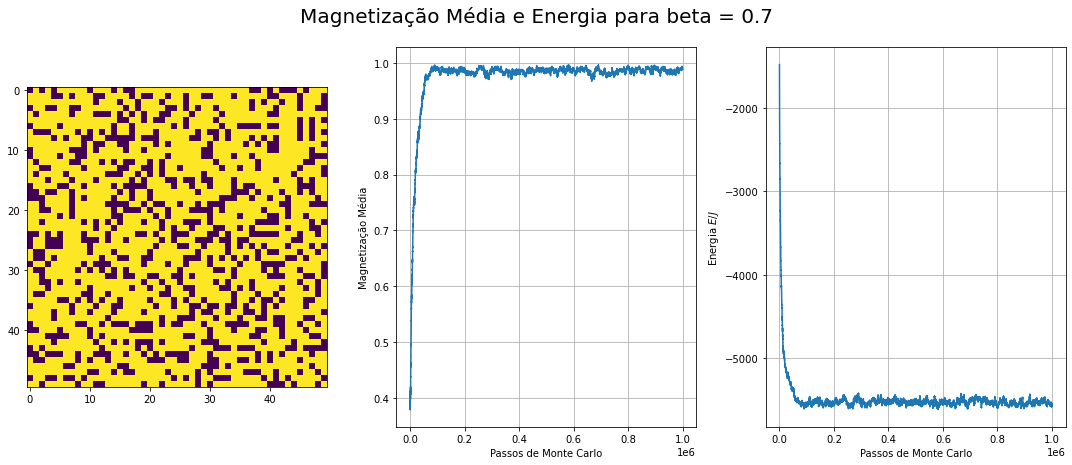

In [15]:
malhaExpl2, spinsExpl2, energiesExpl2 = main(N, tipo, bj, passosMC)
mostrarResultados(malhaExpl2, spinsExpl2, energiesExpl2, bj)

In [16]:
def mostrarDoisResultados(malha1, spins1, energies1, malha2, spins2, energies2, beta):
    bfig, axes = plt.subplots(2, 1, figsize=(20,15))
    ax = axes[0]
    ax.plot(spins1/N**2)
    ax.set_xlabel('Passos de Monte Carlo')
    ax.set_ylabel('Magnetização Média')
    ax.plot(spins2/N**2)
    ax = axes[1]
    ax.plot(energies1)
    ax.set_xlabel('Passos de Monte Carlo')
    ax.set_ylabel(r'Energia $E/J$')
    ax.plot(energies2)
    plt.show()

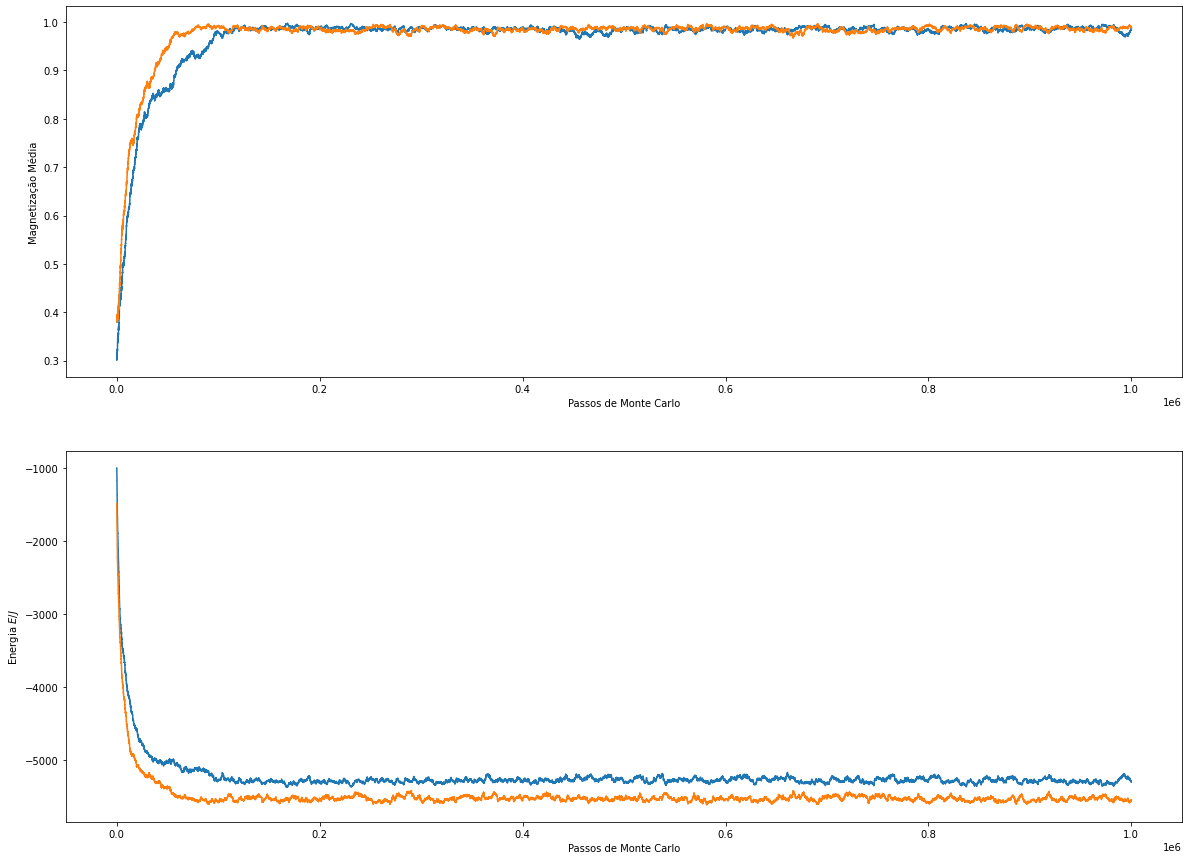

In [19]:
mostrarDoisResultados(malhaExpl1, spinsExpl1, energiesExpl1, malhaExpl2, spinsExpl2, energiesExpl2, bj)

In [23]:
tipo = 5 #malha aleatória

$$T = 0.8 \Rightarrow \beta \cdot J \approx 1.2$$
$$T = 1.4 \Rightarrow \beta \cdot J \approx 0.7$$
$$T = 2.2 \Rightarrow \beta \cdot J \approx 0.45$$

<font size="5">Fixamos o tamanho da malha = 33, e variamos $\beta \cdot J$ nos valores acima:</font>

In [27]:
N = 33
#Visando a eficiência do algoritmo, é interessante o uso do numba.
#Para tanto, ao mudar o tamanho linear da malha é necessário re-definir a função metropolis.
@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(spin_arr, times, BJ, energy): #times = passos
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    for t in range(0,times-1):
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] 
        spin_f = spin_i*-1 
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy
    return net_spins, net_energy

/home/gui/anaconda3/lib/python3.8/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [43]:
betaJ = 1.2
passosMC = 1e5

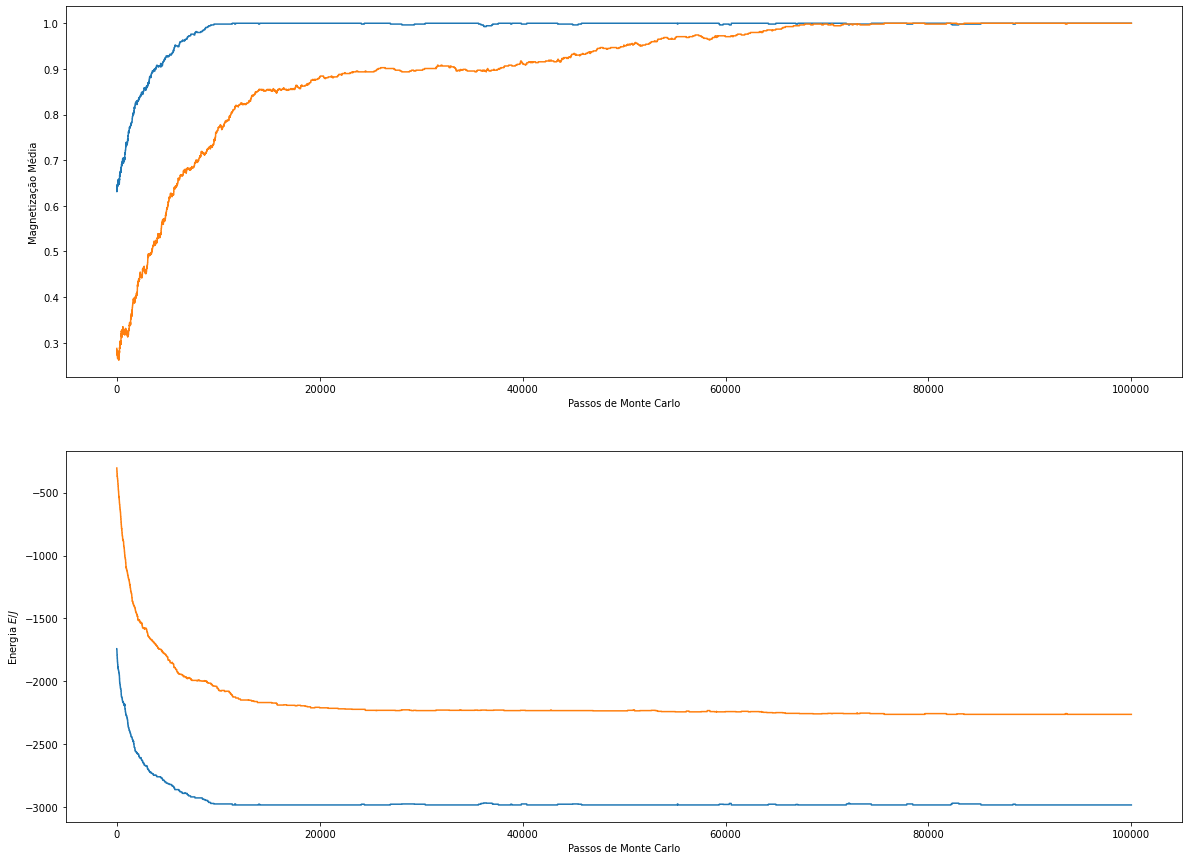

In [46]:
malha1, spins1, energies1 = main(N, tipo, betaJ, passosMC)
malha2, spins2, energies2 = main(N, tipo, betaJ, passosMC)
mostrarDoisResultados(malha1, spins1, energies1, malha2, spins2, energies2, betaJ)

In [41]:
betaJ = 0.7
passosMC = 1e5

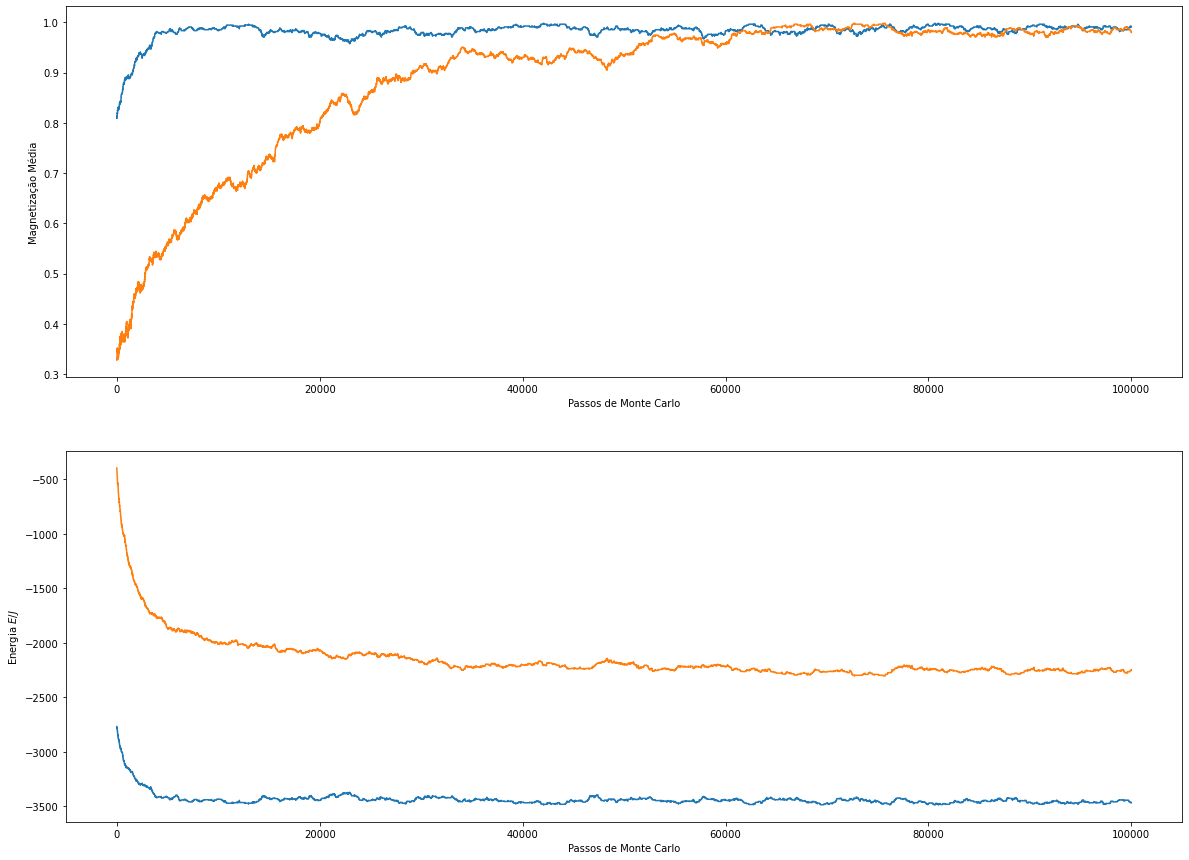

In [42]:
malha1, spins1, energies1 = main(N, tipo, betaJ, passosMC)
malha2, spins2, energies2 = main(N, tipo, betaJ, passosMC)
mostrarDoisResultados(malha1, spins1, energies1, malha2, spins2, energies2, betaJ)

In [84]:
betaJ = 0.45
passosMC = 1e6

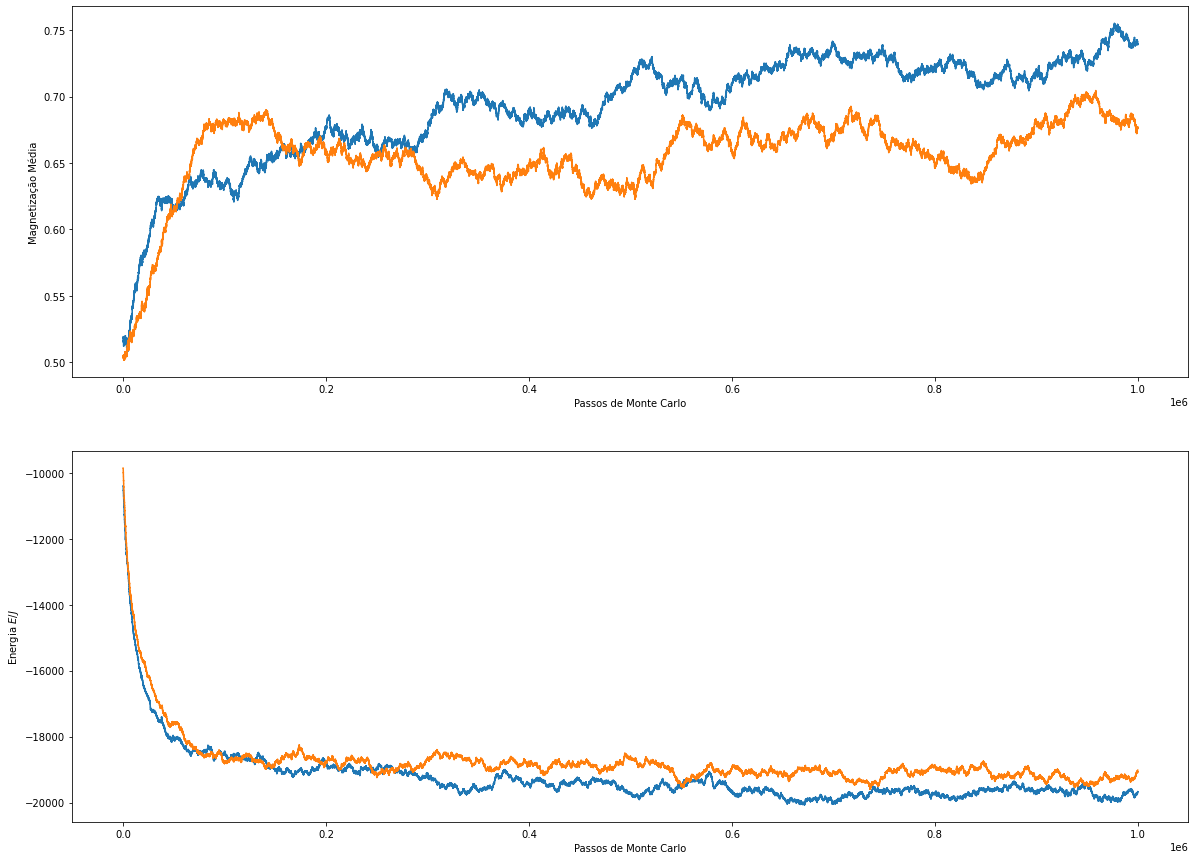

In [85]:
malha1, spins1, energies1 = main(N, tipo, betaJ, passosMC)
malha2, spins2, energies2 = main(N, tipo, betaJ, passosMC)
mostrarDoisResultados(malha1, spins1, energies1, malha2, spins2, energies2, betaJ)

<font size="5"> Fixamos o tamanho da malha = 66, e reproduzimos o processo: </font>

In [62]:
N = 66

@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(spin_arr, times, BJ, energy): #times = passos
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    for t in range(0,times-1):
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] 
        spin_f = spin_i*-1 
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy
    return net_spins, net_energy

/home/gui/anaconda3/lib/python3.8/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [63]:
beta = 1.2
passosMC = 1e5

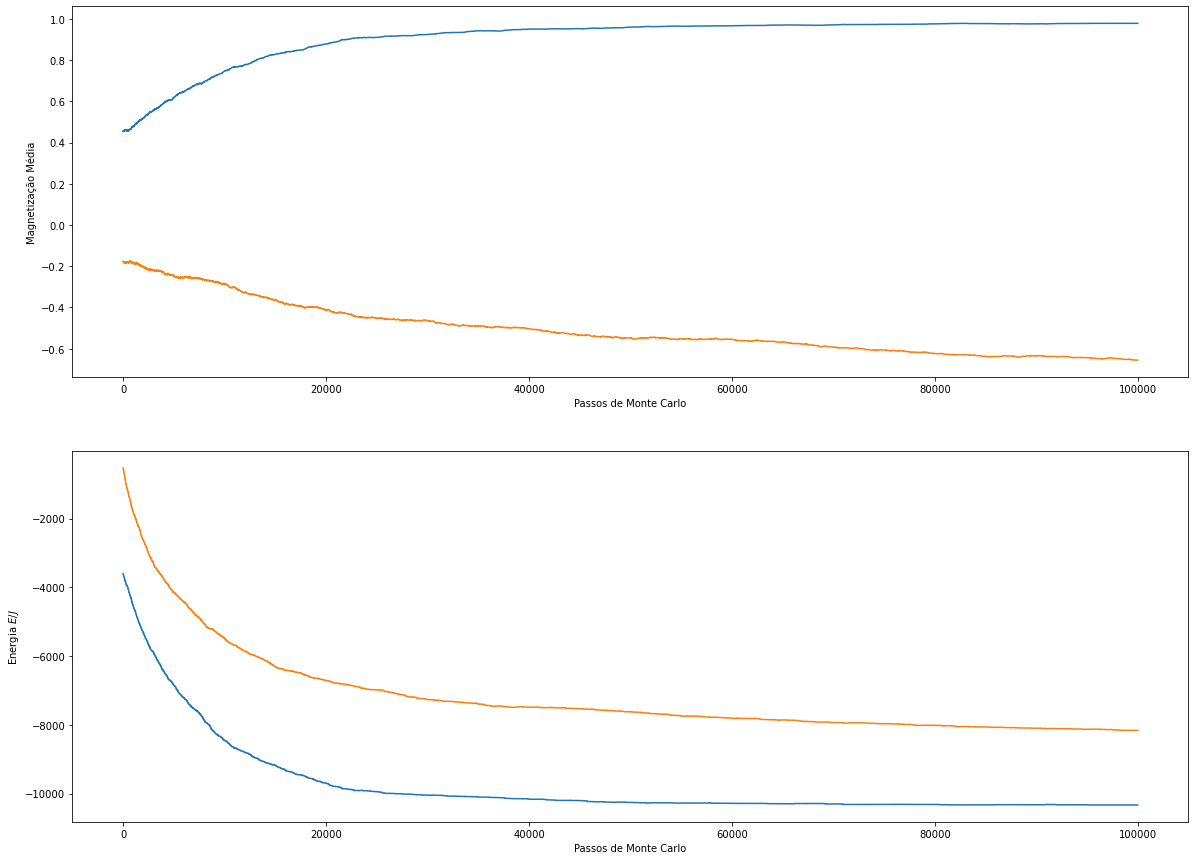

In [65]:
malha1, spins1, energies1 = main(N, tipo, beta, passosMC)
malha2, spins2, energies2 = main(N, tipo, beta, passosMC)
mostrarDoisResultados(malha1, spins1, energies1, malha2, spins2, energies2, beta)

In [66]:
beta = 0.7
passosMC = 1e5

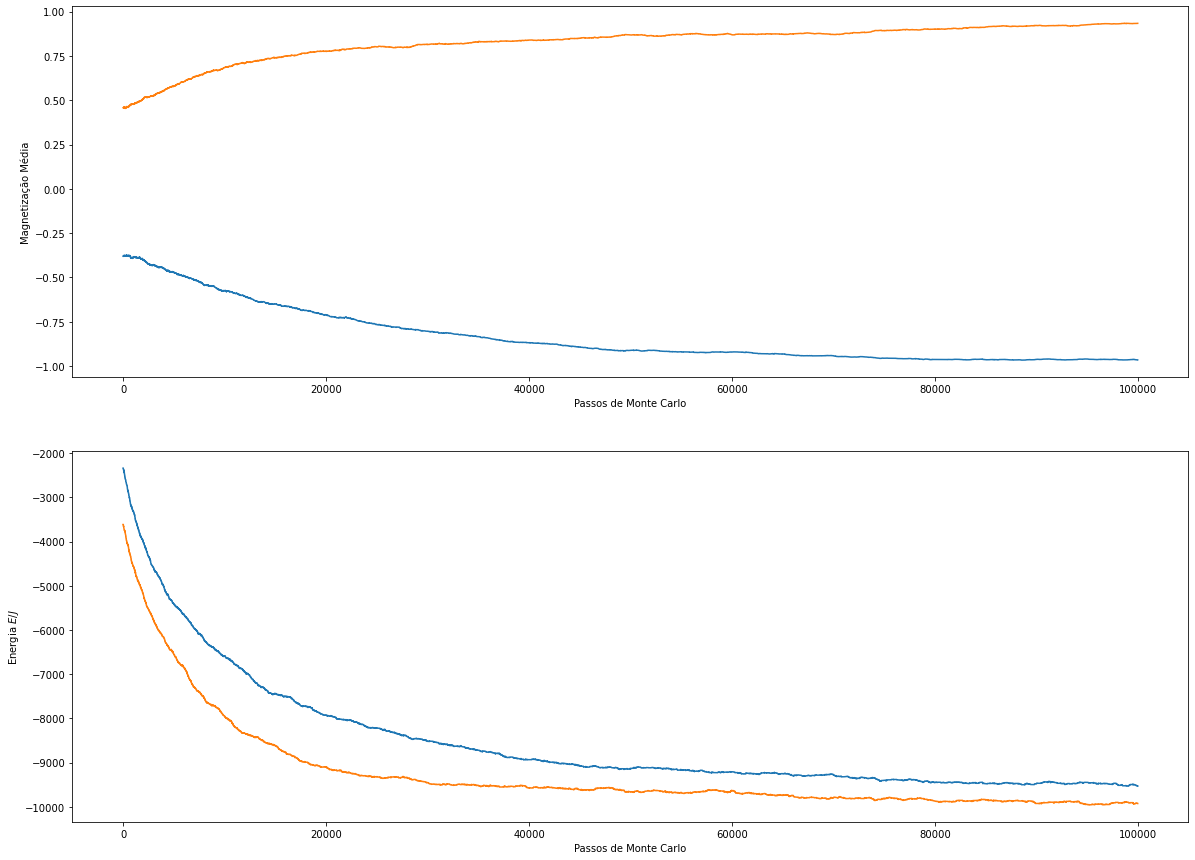

In [67]:
malha1, spins1, energies1 = main(N, tipo, beta, passosMC)
malha2, spins2, energies2 = main(N, tipo, beta, passosMC)
mostrarDoisResultados(malha1, spins1, energies1, malha2, spins2, energies2, beta)

In [74]:
beta = 0.45
passosMC = 1e6

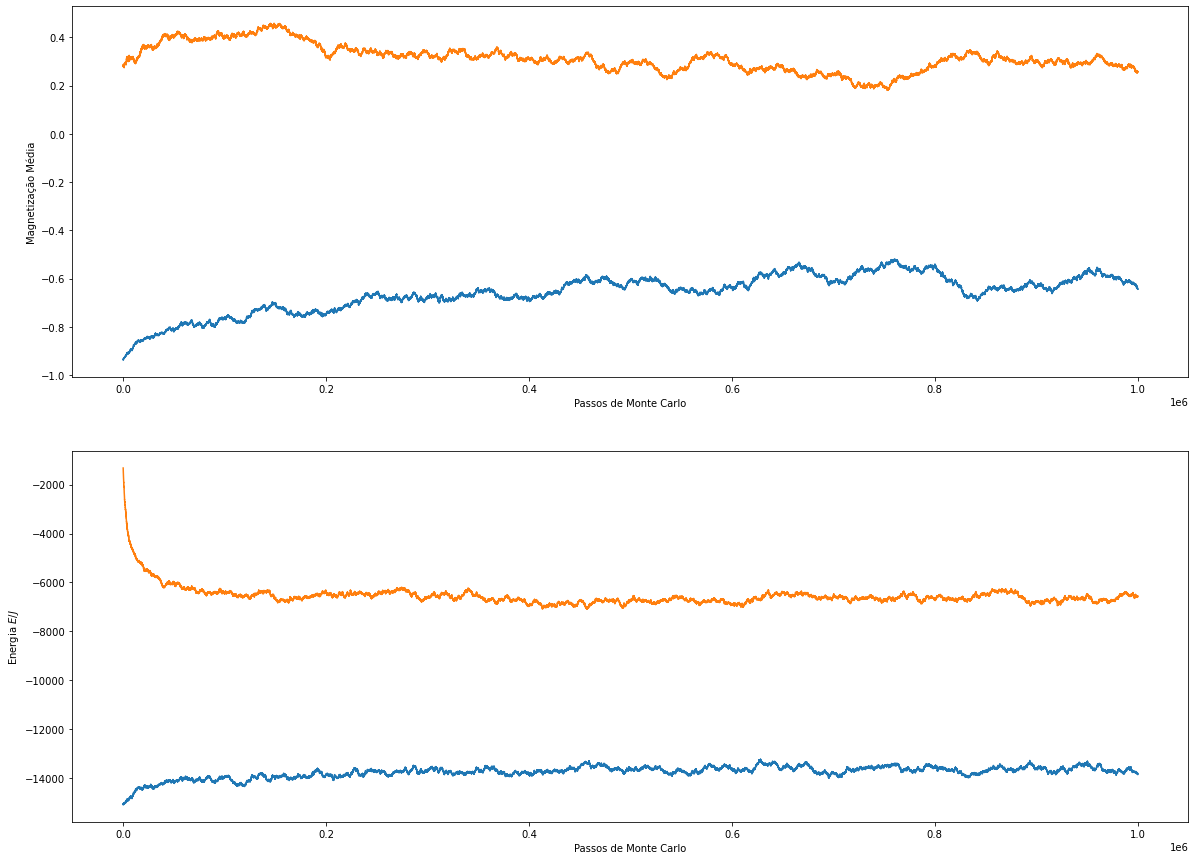

In [75]:
malha1, spins1, energies1 = main(N, tipo, beta, passosMC)
malha2, spins2, energies2 = main(N, tipo, beta, passosMC)
mostrarDoisResultados(malha1, spins1, energies1, malha2, spins2, energies2, beta)

 <font size="5"> Fixamos o tamanho da malha = 99, e reproduzimos o processo: </font>


In [87]:
N = 99

@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(spin_arr, times, BJ, energy): #times = passos
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    for t in range(0,times-1):
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] 
        spin_f = spin_i*-1 
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy
    return net_spins, net_energy

/home/gui/anaconda3/lib/python3.8/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [78]:
betaJ = 1.2
passosMC = 1e5

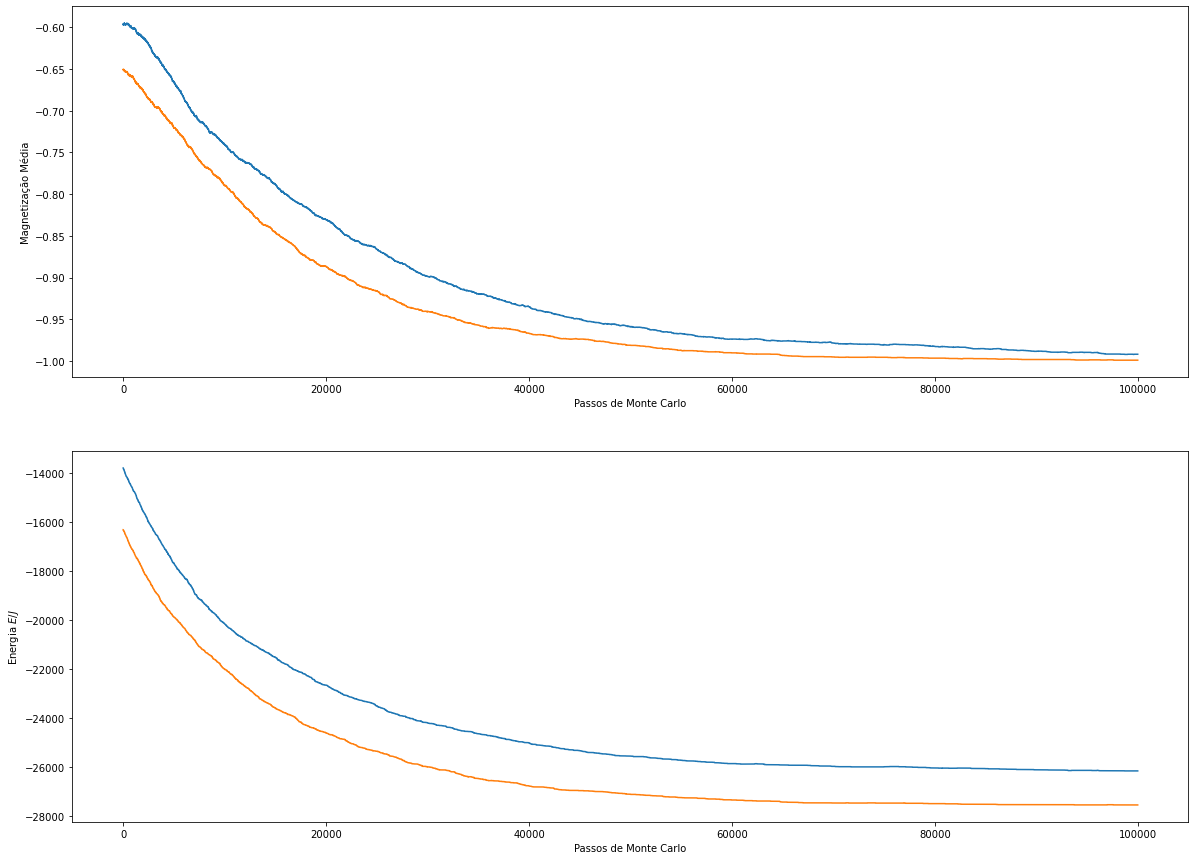

In [79]:
malha1, spins1, energies1 = main(N, tipo, betaJ, passosMC)
malha2, spins2, energies2 = main(N, tipo, betaJ, passosMC)
mostrarDoisResultados(malha1, spins1, energies1, malha2, spins2, energies2, betaJ)

In [80]:
betaJ = 0.7
passosMC = 1e5

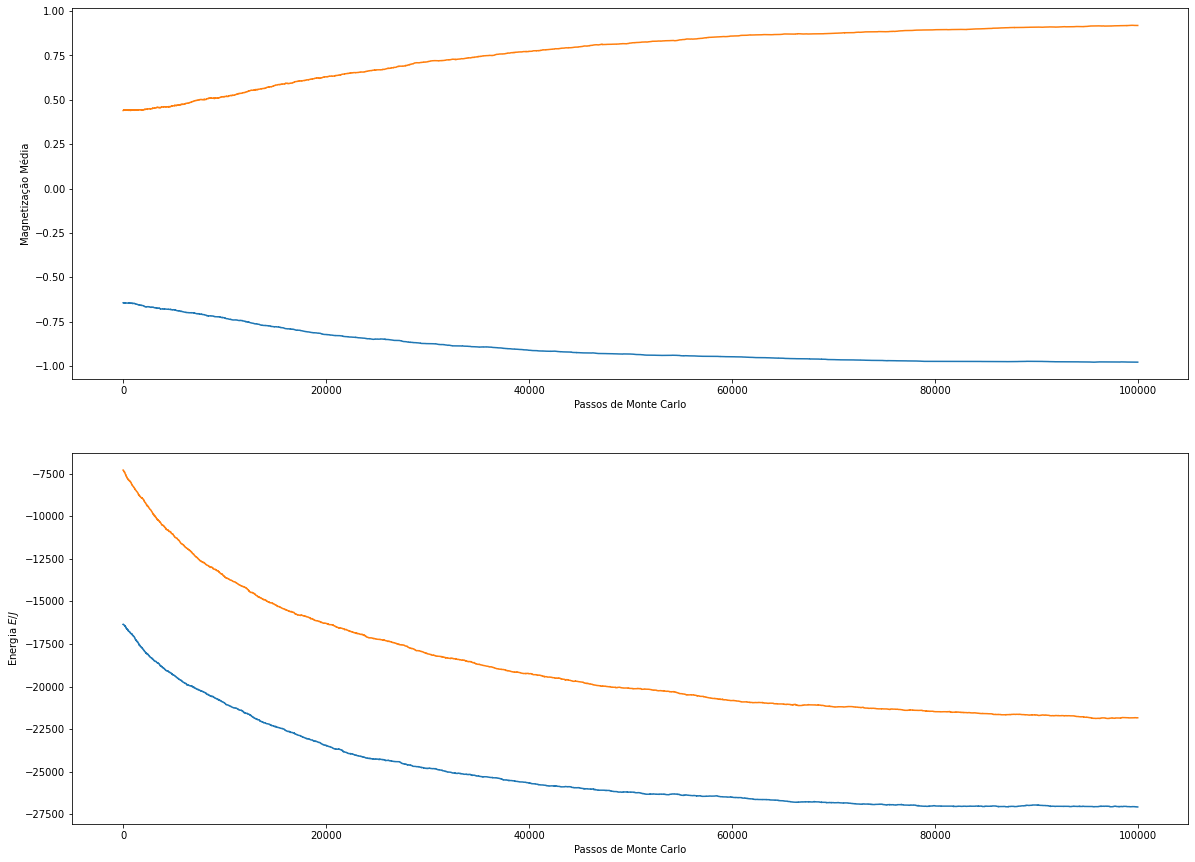

In [81]:
malha1, spins1, energies1 = main(N, tipo, betaJ, passosMC)
malha2, spins2, energies2 = main(N, tipo, betaJ, passosMC)
mostrarDoisResultados(malha1, spins1, energies1, malha2, spins2, energies2, betaJ)

In [88]:
betaJ = 0.45
passosMC = 1e6

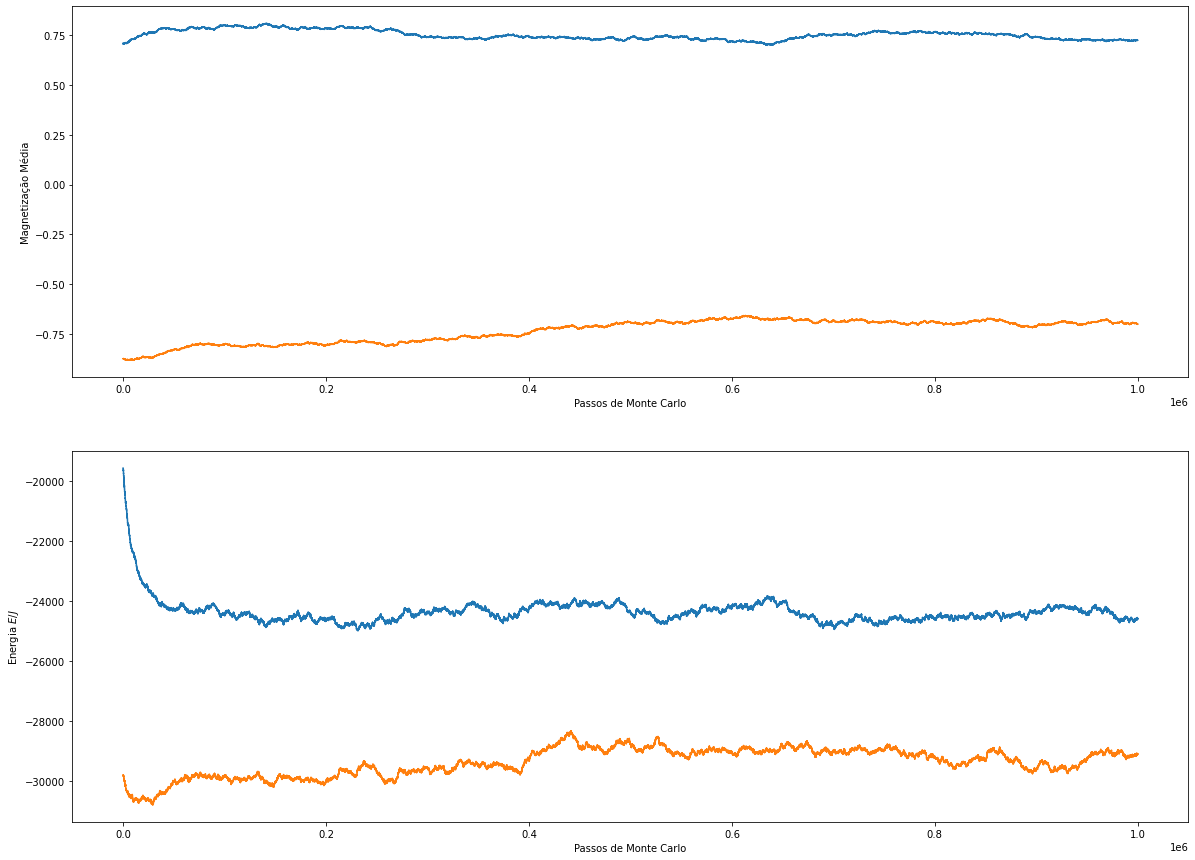

In [90]:
malha1, spins1, energies1 = main(N, tipo, betaJ, passosMC)
malha2, spins2, energies2 = main(N, tipo, betaJ, passosMC)
mostrarDoisResultados(malha1, spins1, energies1, malha2, spins2, energies2, betaJ)

<font size="5"> Verificação de forma qualitativa como o número de passos de termalização varia de acordo com o tamanho do sistema e com a temperatura da simulação: </font>

In [98]:
#![Tabela de Termalização](tabela1.png)
Image(url="tabela1.png", width=300, height=300)

A tabela acima apresenta, nas linhas, valores fixos de temperatura(Beta J), e nas colunas, valores fixos do tamanho da malha. Então, cada valor da tabela é o número qualitativo de quantos passos de monte carlo foi necessário para termalizar o sistema na dada configuração (em uma tupla temperatura-tamanho).